In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pandas as pd
from collections import Counter
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
from urllib import request
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from ppxf.ppxf_util import log_rebin
import os
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
import csv
from scipy import ndimage
import glob
from time import time 
from astropy.wcs import WCS

In [3]:
fluxos='/home/sabrinadopico/Área de trabalho/análise3866/fluxos/'


      X    Y  BIN_NUM  OIII_Hbeta_Ratio  logratio
0  10.0  0.0       19         10.385625  1.016433
1  11.0  0.0       19         10.385625  1.016433
2  12.0  0.0       19         10.385625  1.016433
3  17.0  0.0       18          0.830113 -0.080863
4  18.0  0.0       18          0.830113 -0.080863
      X    Y  BIN_NUM  NII_Halpha_Ratio  logration2ha
0  10.0  0.0       19          0.049197     -1.308064
1  11.0  0.0       19          0.049197     -1.308064
2  12.0  0.0       19          0.049197     -1.308064
3  17.0  0.0       18          0.010516     -1.978162
4  18.0  0.0       18          0.010516     -1.978162


/tmp/ipykernel_21822/1181013960.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, kewley_line(x_range), 'k--', label='Kewley et al. 2001', color='blue', linewidth=1)
/tmp/ipykernel_21822/1181013960.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, kauffmann_line(x_range), 'k-', label='Kauffmann et al. 2003',color='black', linewidth=1)


<Figure size 10000x10000 with 0 Axes>

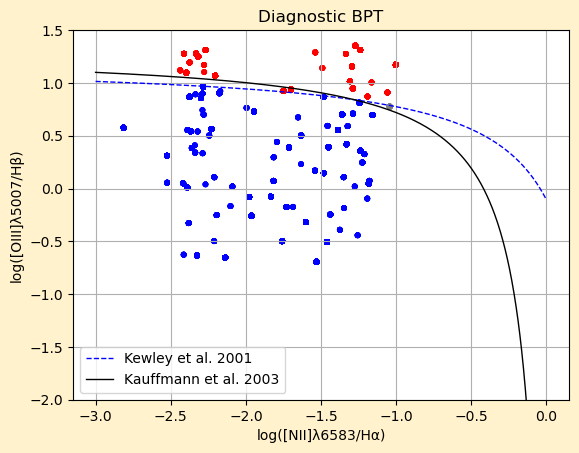

In [4]:
arquivo1 = fluxos+'merged_data_o3hb.dat' 
arquivo2 = fluxos+'merged_data_n2ha.dat' 

data_o3_hbeta = pd.read_csv(arquivo1)
data_n2_halpha = pd.read_csv(arquivo2)
bins_comuns = pd.merge(data_o3_hbeta, data_n2_halpha, on=['BIN_NUM'])
o3_hbeta = bins_comuns['logratio']
n2_halpha = bins_comuns['logration2ha']
print(data_o3_hbeta.head())
print(data_n2_halpha.head())
# Criar o diagrama BPT
# Funções de separação de Kauffmann e Kewley
def kewley_line(x):
    return 0.61 / (x - 0.47) + 1.19

def kauffmann_line(x):
    return 0.61 / (x - 0.05) + 1.3

# Classificação dos pontos com base nas linhas
colors = []
for x, y in zip(n2_halpha, o3_hbeta):
    if y > kewley_line(x):
        colors.append('red')  # AGN dominada
    elif y > kauffmann_line(x):
        colors.append('gray')  # Misturada (SF + AGN)
    else:
        colors.append('blue')  # Formação estelar (SF)

# Criação do gráfico
plt.figure(figsize=(100, 100))
plt.figure(facecolor='#fff2cc')
plt.scatter(n2_halpha, o3_hbeta, c=colors, s=10, marker='o')
plt.xlabel('log([NII]λ6583/Hα)')
plt.ylabel('log([OIII]λ5007/Hβ)')
plt.title('Diagnostic BPT')

# Adicionando as linhas de Kewley et al. 2001 e Kauffmann et al. 2003
x_range = np.linspace(-3.0, 0, 1000)
plt.plot(x_range, kewley_line(x_range), 'k--', label='Kewley et al. 2001', color='blue', linewidth=1)
plt.plot(x_range, kauffmann_line(x_range), 'k-', label='Kauffmann et al. 2003',color='black', linewidth=1)

# Ajustando os limites do gráfico
#plt.xlim(-3.0, 0)
plt.ylim(-2, 1.5)

# Legenda
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_32224/256454102.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, kewley_line(x_range), 'k--', label='Kewley et al. 2001', color='blue', linewidth=1)
/tmp/ipykernel_32224/256454102.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, kauffmann_line(x_range), 'k-', label='Kauffmann et al. 2003', color='black', linewidth=1)


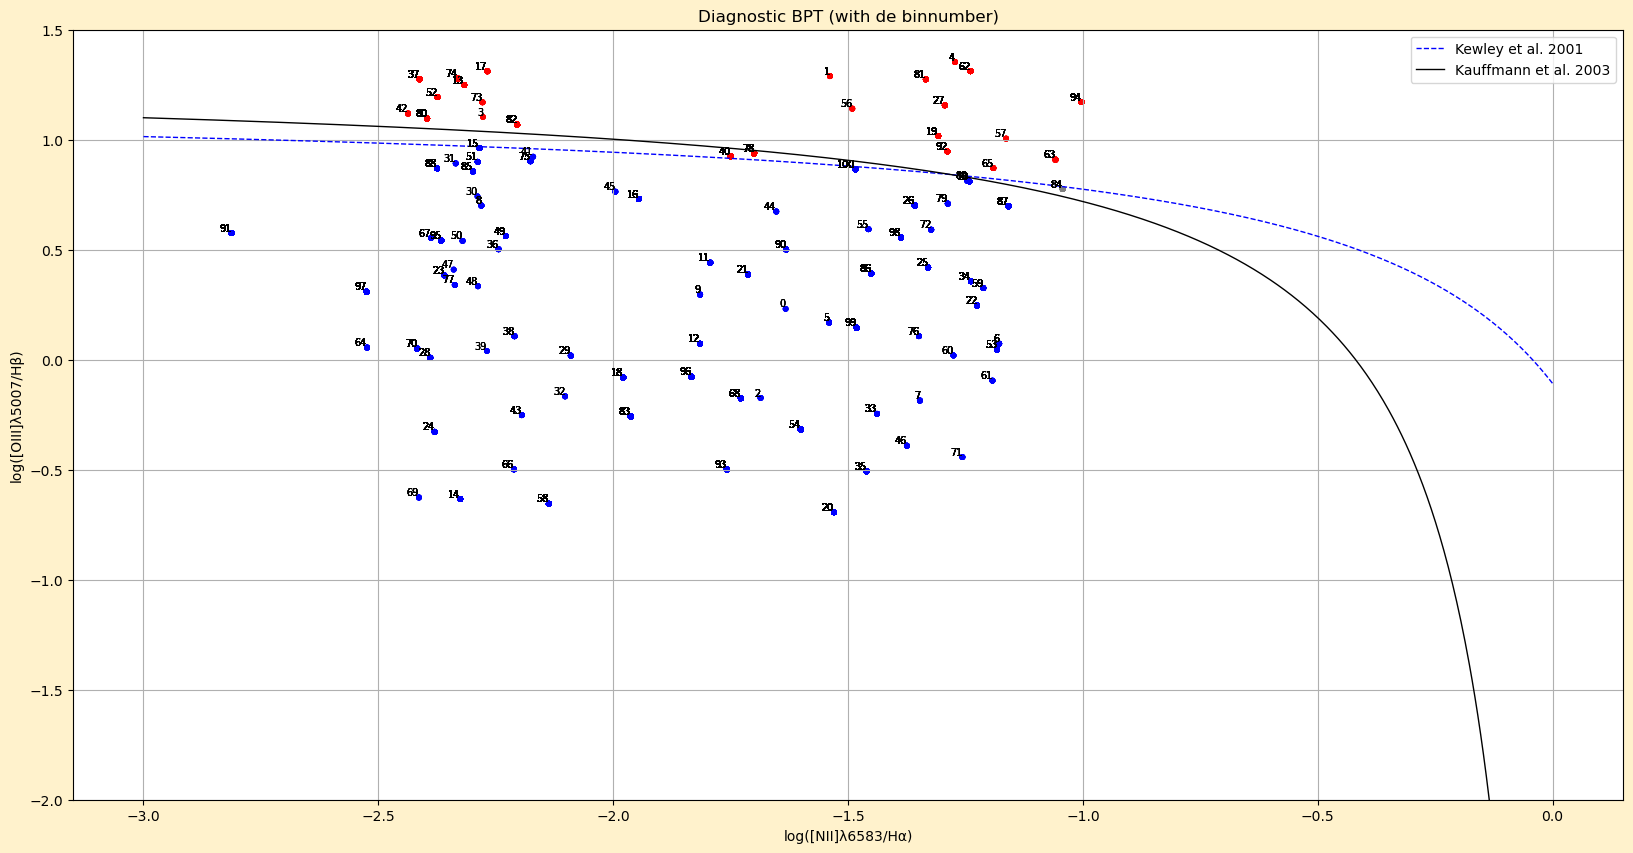

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Carregar dados
data_o3_hbeta = pd.read_csv(arquivo1)
data_n2_halpha = pd.read_csv(arquivo2)
bins_comuns = pd.merge(data_o3_hbeta, data_n2_halpha, on=['BIN_NUM'])

# Definir variáveis
o3_hbeta = bins_comuns['logratio']
n2_halpha = bins_comuns['logration2ha']
bin_num = bins_comuns['BIN_NUM']

# Funções de separação de Kauffmann e Kewley
def kewley_line(x):
    return 0.61 / (x - 0.47) + 1.19

def kauffmann_line(x):
    return 0.61 / (x - 0.05) + 1.3

# Classificação dos pontos com base nas linhas
colors = []
for x, y in zip(n2_halpha, o3_hbeta):
    if y > kewley_line(x):
        colors.append('red')  # AGN dominada
    elif y > kauffmann_line(x):
        colors.append('gray')  # Misturada (SF + AGN)
    else:
        colors.append('blue')  # Formação estelar (SF)


# Criação do gráfico
plt.figure(figsize=(20, 10), facecolor='#fff2cc')  # Define tamanho e cor de fundo aqui
plt.scatter(n2_halpha, o3_hbeta, c=colors, s=10, marker='o')
plt.xlabel('log([NII]λ6583/Hα)')
plt.ylabel('log([OIII]λ5007/Hβ)')
plt.title('Diagnostic BPT (with de binnumber)')


# Adicionando os números dos bins
for i, (x, y) in enumerate(zip(n2_halpha, o3_hbeta)):
    plt.text(x, y, f'{bin_num.iloc[i]}', fontsize=7, ha='right', va='bottom')

# Adicionando as linhas de Kewley et al. 2001 e Kauffmann et al. 2003
x_range = np.linspace(-3.0, 0, 1000)
plt.plot(x_range, kewley_line(x_range), 'k--', label='Kewley et al. 2001', color='blue', linewidth=1)
plt.plot(x_range, kauffmann_line(x_range), 'k-', label='Kauffmann et al. 2003', color='black', linewidth=1)

# Ajustando os limites do gráfico
plt.ylim(-2, 1.5)

# Legenda
plt.legend()
plt.grid(True)
plt.show()




